In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.special import expit, softmax

In [45]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.datasets import make_gaussian_quantiles
real_cov = np.array([[0., 4.],
                     [4., 0.]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean=[0, 0],
                            cov=real_cov,
                            size=500)
cov = EmpiricalCovariance(assume_centered=False).fit(X)
cov.covariance_


cov.location_

<ipython-input-45-6bcdcb4ecde2>:6: RuntimeWarning: covariance is not positive-semidefinite.
  X = rng.multivariate_normal(mean=[0, 0],


array([0.13073138, 0.05029545])

In [21]:
from scipy.stats import shapiro
shapiro(X[:,1])

ShapiroResult(statistic=0.9974537491798401, pvalue=0.6451470255851746)

In [11]:
cov.covariance_

array([[ 1.89558425, -0.01443971],
       [-0.01443971,  0.99986805]])

In [12]:
np.cov(X, rowvar=False, ddof=0)

array([[ 1.89558425, -0.01443971],
       [-0.01443971,  0.99986805]])

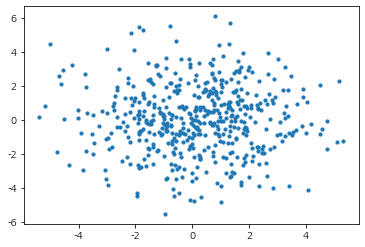

In [46]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:, 1], s=10)

$\large \log P(y=k|x) = \omega_{k}^{t} x + \omega_{k_{0}} + constant$  
where $\omega_{k} = \Sigma^{-1} \mu_{k}$, $\omega_{k_{0}} = -\frac{1}{2} \mu_{k}^t \Sigma^{-1} \mu_{k} + \log{P(y=k)}$

In [2]:
data = load_breast_cancer()
X = data['data']
y = data['target']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [27]:
lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)
lda.fit(X_train, y_train)

pred = lda.predict(X_test)
pred_proba = lda.predict_proba(X_test)

`priors_`

In [22]:
y_train_counts = np.unique(y_train, return_counts=True)[1]
np.alltrue(lda.priors_ == y_train_counts/y_train_counts.sum())

True

`covariance_`

In [23]:
# by numpy cov
covariance = (lda.priors_[0]*np.cov(X_train[y_train==0], rowvar=False, ddof=0) + lda.priors_[1]*np.cov(X_train[y_train==1], rowvar=False, ddof=0))
np.alltrue(lda.covariance_==covariance)

True

In [61]:
# by sklearn empirical_covariance
covariance = (lda.priors_[0]*empirical_covariance(X_train[y_train==0]) + lda.priors_[1]*empirical_covariance(X_train[y_train==1], ))
np.alltrue(lda.covariance_==covariance)

True

In [36]:
c = np.linalg.lstsq(lda.covariance_, lda.means_.T, rcond=None)[0].T

In [40]:
np.isclose(np.array( c[1, :] - c[0, :], ndmin=2, dtype=X_train.dtype), lda.coef_)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])

`means_`

In [24]:
print('shape of means_:', lda.means_.shape)
means = np.array([X_train[y_train==0].mean(axis=0), X_train[y_train==1].mean(axis=0)])
np.alltrue(lda.means_== means)

shape of means_: (2, 30)


True

`xbar_` only in svd solver

In [ ]:
print('shape of xbar_:', lda.xbar_.shape)
print(np.allclose(lda.xbar_, X_train.mean(axis=0)))
print(np.alltrue(lda.xbar_ == np.dot(lda.priors_, lda.means_)))

`predict_proba`

In [28]:
np.alltrue(pred_proba[:, 1] == expit(lda.decision_function(X_test)) )

True

`decision_function`

In [29]:
np.alltrue(lda.decision_function(X_test) == ((X_test).dot(lda.coef_.T) + lda.intercept_).flatten())

True

# Solver

## svd

`coef_`

[reference for implementing svd solver](https://github.com/scikit-learn/scikit-learn/blob/0d378913be6d7e485b792ea36e9268be31ed52d0/sklearn/discriminant_analysis.py#L470)

In [53]:
Xc = []
for idx, group in enumerate(lda.classes_):
    Xg = X_train[y_train == group, :]
    Xc.append(Xg - lda.means_[idx])
    
Xc = np.concatenate(Xc, axis=0)


n_samples, n_features = X_train.shape
n_classes = len(lda.classes_)

std = Xc.std(axis=0)
std[std == 0] = 1.0
fac = 1.0 / (n_samples - n_classes)

# 1. SVD of centered input matrix X(X_train)
X_train_ = np.sqrt(fac) * (Xc / std)
U, S, Vt = np.linalg.svd(X_train_, full_matrices=False)

rank = np.sum(S > lda.tol)
scalings = (Vt[:rank] / std).T / S[:rank]


# 2. SVD of the class-wise mean vectors
X_train_0 = np.dot(
    (
        (np.sqrt((n_samples * lda.priors_) * fac))
        * (lda.means_ - lda.xbar_).T
    ).T,
    scalings,
)

_, S, Vt = np.linalg.svd(X_train_0, full_matrices=0)


rank = np.sum(S > lda.tol * S[0])
scalings_ = np.dot(scalings, Vt.T[:, :rank])
coef = np.dot(lda.means_ - lda.xbar_, scalings_)
intercept_ = -0.5 * np.sum(coef ** 2, axis=1) + np.log(lda.priors_)
coef_ = np.dot(coef, scalings_.T)
intercept_ -= np.dot(lda.xbar_, coef_.T)

if n_classes==2:
    coef_ = np.array( coef_[1, :] - coef_[0, :], ndmin=2, dtype=X_train.dtype)

In [54]:
np.allclose(lda.coef_ , coef_)

True

`intercept_`

In [55]:
if n_classes==2:
    intercept_ =  np.array(  intercept_[1] - intercept_[0], ndmin=1, dtype=X_train.dtype )

In [56]:
np.allclose(lda.intercept_ , intercept_)

True

## 'lsqr'

`coef_`

In [62]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [100]:
coef_ = np.linalg.lstsq(lda.covariance_, lda.means_.T, rcond=None)[0].T
intercept_ = -0.5 * np.diag(np.dot(lda.means_, coef_.T)) + np.log(
            lda.priors_
        )

if n_classes==2:
    coef_ = np.array( coef_[1, :] - coef_[0, :], ndmin=2, dtype=X_train.dtype)

In [101]:
np.allclose(lda.coef_ , coef_)

True

In [102]:
if n_classes==2:
    intercept_ =  np.array(  intercept_[1] - intercept_[0], ndmin=1, dtype=X_train.dtype )

In [103]:
np.allclose(lda.intercept_ , intercept_)

True